In [135]:
# general
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# bootstrapped
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

sns.set()

In [136]:
def plot_error_distribution(control_group, test_group, test_group_name, bins=30):
    plt.figure(figsize=(10, 6))
    bins = np.linspace(
        df_user_error['error'].min(),
        df_user_error['error'].max(),
        bins
    )

    plt.hist(control_group, bins=bins, label="No feedback (control group)", alpha=0.5)
    plt.hist(test_group, bins=bins, label=f"{test_group_name} (test group)", color='orange', alpha=0.5)
    plt.title('Test/Ctrl Data')
    plt.legend()
    

def get_confidence_intervals(test_group, control_group):
    ab = bs.bootstrap_ab(np.array(test_group), np.array(control_group), bs_stats.mean, bs_compare.percent_change)
    return ab.value, ab.lower_bound, ab.upper_bound

In [146]:
METRICS = ["me", "mae"]
TEST_GROUP_NAMES = ['low quality feedback', 'medium quality feedback', 'high quality feedback']

# 1. General statistics
## 1.1. Read data

In [137]:
df = pd.read_csv('../../data/ebay_items_weight/ebay_items_weight-dataset.csv')

## 1.2. Compute user's annotation error metrics
- In this section we aggregate the raw result to compute the mean error value per user
- Error value is defined using MAE (Mean absolute error) and ME (Mean error) metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [129]:
data = []
for (test_group, user_feedback, user_id), group in df.groupby(['test_group', 'user__feedback', 'user__id']):
    y_true = group['reference__output']
    y_pred = group['annotation__output']
    
    data.append({
        'test_group': test_group,
        'user__feedback': user_feedback,
        'user__id': user_id,
        'count': len(group),
        "mae": (y_true - y_pred).abs().mean(),
        "mse": (y_true - y_pred).pow(2).mean(),
        "me": (y_true - y_pred).mean()
    })

df_user_error = pd.DataFrame(data)

In [130]:
pd.merge(
    df_user_error,
    df_user_error.groupby(
        ['test_group', 'user__feedback']
    )['user__id'].count().to_frame('users_count'),
    on=['test_group', 'user__feedback']
).groupby(
    ['test_group', 'user__feedback', 'users_count']
)[METRICS].aggregate(['mean', 'std'])

me              \
                                                          mean         std   
test_group              user__feedback users_count                           
high quality feedback   False          63           754.691431  470.959526   
                        True           50           280.244484  354.223784   
low quality feedback    True           35            24.700100  451.729740   
medium quality feedback True           37             6.316163  287.825563   

                                                            mae              
                                                           mean         std  
test_group              user__feedback users_count                           
high quality feedback   False          63           1007.893114  288.972710  
                        True           50            904.866740  222.346516  
low quality feedback    True           35           1121.656058  252.441844  
medium quality feedback True           37            955.083211  245.268897

## 1.3. Error distribution for control group and high quality feedback test group
Below you can see a plot showing a error distribution difference for the control group and the test group with the high quality feedback
### 1.3.1. Histogram

In [118]:
test_group_name = "high quality feedback"

control_group = df_user_error[
    (df_user_error['test_group'] == "high quality feedback") &
    (df_user_error['user__feedback'] == False)
]['error']
    
test_group = df_user_error[
    (df_user_error['test_group'] == test_group_name) &
    (df_user_error['user__feedback'] == True)
]['error']

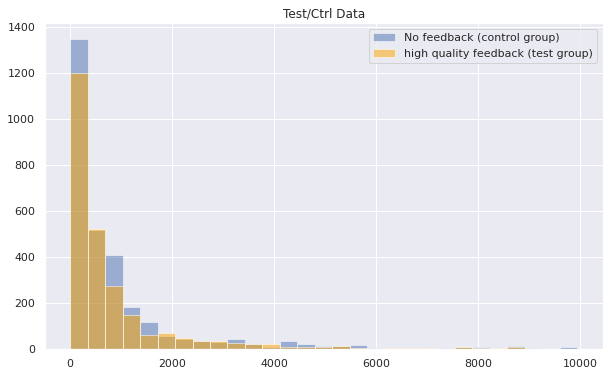

In [119]:
plot_error_distribution(control_group, test_group, test_group_name)

### 1.3.1. Boxplot

In [140]:
_df = df_user_error.copy()
_df.loc[_df['user__feedback'] == False, 'test_group'] = "control group"

<AxesSubplot:title={'center':'Distribution of MAE between test groups'}, xlabel='test_group', ylabel='mae'>

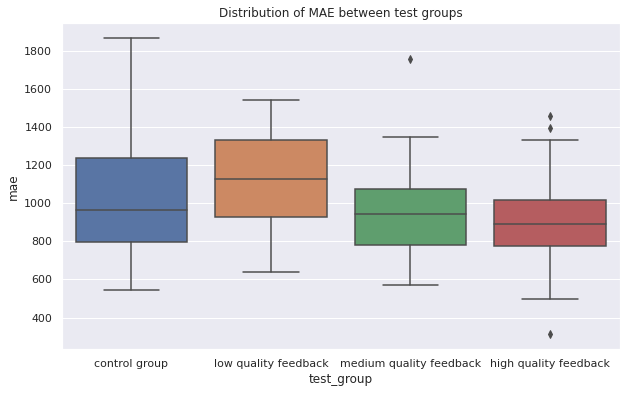

In [145]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of MAE between test groups")
sns.boxplot(x='test_group', y='mae', data=_df, order=["control group"] + TEST_GROUP_NAMES)

# 2. Confidence intervals
## 2.1. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage error reduction between the control group and each of the test groups.

In [134]:
data = []

for metric in METRICS:
    
    control_group = df_user_error[
        (df_user_error['test_group'] == "high quality feedback") &
        (df_user_error['user__feedback'] == False)
    ][metric]
    
    for test_group_name in TEST_GROUP_NAMES:
        test_group = df_user_error[
            (df_user_error['test_group'] == test_group_name) &
            (df_user_error['user__feedback'] == True)
        ][metric]
        mean, lower_bound, upper_bound = get_confidence_intervals(test_group, control_group)

        data.append({
            "test_group_name": test_group_name,
            "metric": metric,
            "lower_bound": lower_bound,
            "mean": mean,
            "upper_bound": upper_bound
        })

pd.DataFrame(data)

,test_group_name,metric,lower_bound,mean,upper_bound
0,low quality feedback,me,-116.663328,-96.727126,-77.468684
1,medium quality feedback,me,-112.216326,-99.163080,-87.816555
2,high quality feedback,me,-78.069194,-62.866349,-49.631576
3,low quality feedback,mae,-0.599941,11.287203,22.143864
4,medium quality feedback,mae,-16.114084,-5.239633,4.310524
5,high quality feedback,mae,-19.498465,-10.221954,-2.103620
